# Objectifs, Définitions et Choix du Modèle Physique

## 1. Objectif de la Modélisation Physique

L'objectif de cette première phase est d'établir un modèle déterministe prédisant la consommation d'énergie électrique (kWh/100km) d'un véhicule électrique (VE) à partir des principes fondamentaux de la dynamique du véhicule.
Ce modèle servira de couche de base interprétable pour l'approche hybride, dont l'erreur résiduelle sera corrigée par un algorithme d'apprentissage automatique (ML).


## 2. Définition des Équations Fondamentales

L'énergie électrique totale consommée ($E$) par la batterie est dérivée de la puissance requise ($P_{\text{total}}$), ajustée par l'efficacité du groupe motopropulseur ($\eta_{\text{drivetrain}}$).

### 2.1. Puissance Totale et Efficacité
L'énergie consommée est l'intégrale de la puissance tirée de la batterie sur le temps de trajet4:$$\mathbf{E}=\int \left(\frac{P_{\text{traction}}+P_{\text{aux}}}{\eta_{\text{drivetrain}}}\right) dt$$Où $P_{\text{traction}} = F_{\text{resistance}} \cdot v$, la puissance nécessaire pour vaincre les forces de résistance à une vitesse $v$.

### 2.2. Forces de Résistance ($F_{\text{resistance}}$)
La force totale de résistance est la somme des composantes suivantes:$$F_{\text{resistance}} = F_{\text{drag}} + F_{\text{rolling}} + F_{\text{grade}}$$**A. Force Aérodynamique** ($F_{\text{drag}}$) $$F_{\text{drag}} = \frac{1}{2} \rho C_d A v^2$$

$\rho$: Densité de l'air (constante, $1.225 \text{ kg}/\text{m}^3$)

$C_d$: Coefficient de traînée

$A$: Surface frontale du véhicule ($\text{m}^2$)

$v$: Vitesse du véhicule ($\text{m}/\text{s}$).


**B.Force de Résistance au Roulement** ($F_{\text{rolling}}$) $$F_{\text{rolling}} = C_r m g \cos(\theta)$$$C_r$: Coefficient de résistance au roulement

$m$: Masse totale du véhicule ($\text{kg}$)

$g$: Accélération gravitationnelle ($9.81 \text{ m}/\text{s}^2$)

$\theta$: Angle de la pente (Radians).

**C.Force de Résistance de Pente** ($F_{\text{grade}}$) $$F_{\text{grade}} = m g \sin(\theta)$$

### 2.3. Puissance Auxiliaire ($P_{\text{aux}}$)
La puissance auxiliaire est dominée par le chauffage et la climatisation (HVAC). Pour les besoins de la Phase 1, un modèle simple basé sur l'écart de température est appliqué:$$P_{\text{aux}} = P_{\text{HVAC}} + P_{\text{electronics}}$$$$P_{\text{HVAC}} \approx k_{\text{base}} + k_{\text{HVAC}} \cdot |T_{\text{ambient}}-T_{\text{set}}|$$

$T_{\text{ambient}}$: Température ambiante

$T_{\text{set}}$: Température de consigne (fixée à $20^{\circ}C$ par défaut)

$k_{\text{base}}, k_{\text{HVAC}}$: Coefficients de puissance HVAC (estimés ou calibrés).

**Hypothèses Appliquées et Simplifications**

Afin de maintenir la simplicité et la transférabilité du modèle de base, les hypothèses suivantes sont appliquées pour la Phase 1 :

**Vitesse Constante (Agrégée)** : Le modèle fonctionne sur la vitesse moyenne du voyage. Les effets dynamiques (accélération/décélération) sont capturés globalement par l'erreur résiduelle et seront modélisés par la couche ML.

**Conditions Statiques de l'Air :** La densité de l'air ($\rho$) est supposée constante, ignorant les faibles variations dues à la température et à l'altitude sur un trajet typique.

**Efficacité Constante :** L'efficacité du groupe motopropulseur ($\eta_{\text{drivetrain}}$) est fixée à une valeur moyenne (ex: 90%), ignorant les variations dues au point de fonctionnement du moteur ou à l'état de charge de la batterie. Ces variations seront corrigées par la couche ML.

**Absence de Régénération :** La récupération d'énergie au freinage n'est pas explicitement modélisée par des formules physiques détaillées. L'effet agrégé de la régénération sera implicitement inclus dans le terme de correction ML.


In [1]:
# --- CONSTANTES PHYSIQUES ---
G = 9.81           # Gravité (m/s²)
RHO_AIR = 1.225    # Densité de l'air (kg/m³)

# --- PARAMÈTRES ESTIMÉS DU VÉHICULE STANDARD ---
# Ces valeurs peuvent être ajustées plus tard pour la calibration.
STANDARD_EV_PARAMS = {
    'mass': 1500,     # Masse à vide (kg)
    'cd': 0.28,       # Coefficient de traînée
    'cr': 0.01,       # Résistance au roulement
    'A': 2.3,         # Surface frontale (m²)
    'motor_eff': 0.90,# Efficacité moteur/drivetrain (90%)

    # Paramètres HVAC (W)
    'hvac_base_power': 500,
    'hvac_temp_coeff': 50, # 50W par degré d'écart
    'temp_set': 20         # Température de consigne (°C)
}

print("Paramètres du Véhicule :")
for k, v in STANDARD_EV_PARAMS.items():
    print(f"- {k}: {v}")

Paramètres du Véhicule :
- mass: 1500
- cd: 0.28
- cr: 0.01
- A: 2.3
- motor_eff: 0.9
- hvac_base_power: 500
- hvac_temp_coeff: 50
- temp_set: 20


## Implémentation de la Classe PhysicsEVModel

In [2]:
import numpy as np

class PhysicsEVModel:
    """
    Modèle physique déterministe pour la prédiction de la consommation d'énergie
    d'un VE (kWh/100km) basé sur les forces de résistance.
    """

    def __init__(self, vehicle_params):
        """Initialise le modèle avec les paramètres du véhicule."""
        self.mass = vehicle_params['mass']
        self.cd = vehicle_params['cd']
        self.cr = vehicle_params['cr']
        self.A = vehicle_params['A']
        self.motor_eff = vehicle_params['motor_eff']

        # Paramètres HVAC
        self.hvac_base_power = vehicle_params['hvac_base_power']
        self.hvac_temp_coeff = vehicle_params['hvac_temp_coeff']
        self.temp_set = vehicle_params['temp_set']

        # Constantes physiques
        self.G = 9.81
        self.RHO_AIR = 1.225

    def energy_per_100km(self, avg_speed_kmh: float, temp_c: float, payload_kg: float, grade_percent: float) -> float:
        """
        Calcule la consommation d'énergie (kWh/100km).

        Args:
            avg_speed_kmh: Vitesse moyenne (km/h).
            temp_c: Température ambiante (°C).
            payload_kg: Charge utile (kg).
            grade_percent: Pente de la route (degrés ou pourcentage, selon l'interprétation).
        """

        # Vérification de la vitesse pour éviter division par zéro et calculer la force
        if avg_speed_kmh <= 1.0:
            return 0.0

        # 1. Préparation des variables et des conversions
        mass_total = self.mass + payload_kg     # Masse totale (kg)
        v_mps = avg_speed_kmh / 3.6             # Vitesse (m/s)
        theta_rad = np.radians(grade_percent)   # Angle de pente (Radians)

        # 2. Calcul des Forces de Résistance (Newtons)

        # Aérodynamique (F_drag)
        f_drag = 0.5 * self.RHO_AIR * self.cd * self.A * (v_mps**2)

        # Roulement (F_rolling)
        f_rolling = self.cr * mass_total * self.G * np.cos(theta_rad)

        # Pente (F_grade)
        f_grade = mass_total * self.G * np.sin(theta_rad)

        # Force de traction totale requise (N)
        f_total_traction = f_drag + f_rolling + f_grade

        # 3. Calcul des Puissances (Watts)

        # Puissance de traction (P_traction)
        p_traction = f_total_traction * v_mps

        # Puissance HVAC (P_hvac)
        p_hvac = self.hvac_base_power + self.hvac_temp_coeff * abs(temp_c - self.temp_set)

        # Puissance électrique totale tirée de la batterie (P_total_battery)
        p_total_battery = (p_traction + p_hvac) / self.motor_eff

        # 4. Conversion en Énergie par 100 km (kWh/100km)
        # Formule simplifiée : P(W) * 100(km) / (V(km/h) * 1000 W/kW)
        energy_per_100km = p_total_battery * 100 / (avg_speed_kmh * 1000)

        return energy_per_100km

## Tests de Validation Initiale

In [3]:
# --- INSTANCIATION ET TESTS ---
base_model = PhysicsEVModel(STANDARD_EV_PARAMS)

print("\n--- Validation Initiale du Modèle Physique ---")

# Cas de test 1 : Autoroute (Haute Vitesse, conditions optimales)
e1 = base_model.energy_per_100km(avg_speed_kmh=110, temp_c=20, payload_kg=0, grade_percent=0)
print(f"1. Autoroute (110 km/h, 20°C, Plat): {e1:.2f} kWh/100km")
# Attendu: ~18-22 kWh/100km

# Cas de test 2 : Froid Extrême (Impact du HVAC)
e2 = base_model.energy_per_100km(avg_speed_kmh=80, temp_c=-10, payload_kg=100, grade_percent=0)
print(f"2. Froid (-10°C, 80 km/h, Charge): {e2:.2f} kWh/100km")
# Attendu: > Cas 1, à cause du chauffage

# Cas de test 3 : Montée (Impact de F_grade)
e3 = base_model.energy_per_100km(avg_speed_kmh=60, temp_c=20, payload_kg=0, grade_percent=5)
print(f"3. Montée (5% Pente, 60 km/h): {e3:.2f} kWh/100km")
# Attendu: Nettement plus élevé que Cas 1 ou 2

# Cas de test 4 : Vitesse très faible (Ville)
e4 = base_model.energy_per_100km(avg_speed_kmh=40, temp_c=20, payload_kg=0, grade_percent=0)
print(f"4. Ville (40 km/h, Plat): {e4:.2f} kWh/100km")
# Attendu: Plus faible que Cas 1 (moins d'aérodynamisme)


--- Validation Initiale du Modèle Physique ---
1. Autoroute (110 km/h, 20°C, Plat): 16.41 kWh/100km
2. Froid (-10°C, 80 km/h, Charge): 13.63 kWh/100km
3. Montée (5% Pente, 60 km/h): 48.42 kWh/100km
4. Ville (40 km/h, Plat): 7.43 kWh/100km


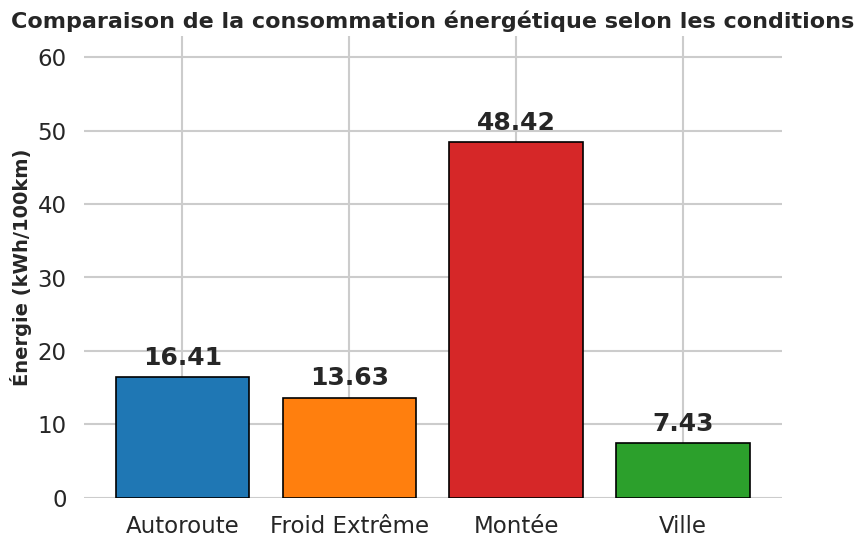

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Activer le style seaborn pour un rendu moderne
sns.set_style("whitegrid")
sns.set_context("talk")  # taille des textes adaptée

# Noms des cas de test
tests = ["Autoroute", "Froid Extrême", "Montée", "Ville"]

# Valeurs correspondantes
energies = [e1, e2, e3, e4]

# Couleurs personnalisées
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#2ca02c"]

# Création du graphique
plt.figure(figsize=(9,6))
bars = plt.bar(tests, energies, color=colors, edgecolor='black', linewidth=1.2)

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}", ha='center', va='bottom', fontweight='bold')

# Titres et labels
plt.ylabel("Énergie (kWh/100km)", fontweight='bold', fontsize=14)
plt.title("Comparaison de la consommation énergétique selon les conditions", fontsize=16, fontweight='bold')

# Ajuster les limites
plt.ylim(0, max(energies)*1.3)

# Supprimer les bordures inutiles
sns.despine(left=True, bottom=True)

plt.show()
